# Introduction

This notebook has 3 parts:
- Sourcing the DSM from the Vexcel API and create a single TIF as a Mosaic
- Converting that DSM into a LAS point cloud
- Creating a mesh from that point cloud and texturing it with the ortho imagery to create a simple digitial twin

It uses common data science and GIS python libraries:
- geopandas
- rasterio
- numpy
- PIL (Python Image Library)

It also uses laspy to handle the conversion of the numpy point cloud to LAS format.

## 1. Sourcing DSM data

There is only one input required, the coordinates of the bounding box of the polygon of interest. You could of course read in your own shapefile or load a WKT, but for simplicity we'll just use the bounding box here.

In [2]:
minx, miny, maxx, maxy = -122.37538397312163, 47.653955469099174, -122.3717737197876, 47.655791098820224

In [3]:
from shapely.geometry import box

aoi_geometry = box(minx, miny, maxx, maxy)

In [4]:
from vdp_python_tools.visualize import visualize_geometry_on_map

visualize_geometry_on_map(aoi_geometry)

Zoom is set to 17 which is a lower resolution than you might use in production. Just so the cells run relatively quickly, set the zoom to 17 at first to make sure the pipeline runs smoothly for your AOI and then increase to 21. This is especially important if you're looking to run a mesh calculation at the end where the calculation and texturing of the mesh with ortho imagery at zoom level 21 takes hours to run on a typical machine.

The `download_and_mosaic_in_geometry` function takes care of both the downloading and mosaicing of the data.

If you'd like mosaic'd data to be downloaded somewhere specific, you can change the filepaths in the cell below before running it.

In [5]:
from vdp_python_tools.get_images import download_and_mosaic_in_geometry

filepath_output_dsm = "./data/tmp/DSM"
filepath_output_ortho = "./data/tmp/Ortho"

zoom = 17

imagery_type = "dsm"
download_and_mosaic_in_geometry(aoi_geometry, zoom, imagery_type, filepath_output_dsm, 3857)

imagery_type = "ortho-urban-area"
download_and_mosaic_in_geometry(aoi_geometry, zoom, imagery_type, filepath_output_ortho, 3857)

Running 1 requests to download 0.000256Gb of data...
...finished downloading data
Running 1 requests to download 0.000256Gb of data...
...finished downloading data


## Step 2: Converting that DSM into a LAS point cloud

The DSM is just a 2D array of elevation data. Since we know the geospatial bounds of the array, we can determine the coordinate for each pixel and generate a point cloud in that way. The Ortho imagery's RGB data is also subject to the same reference frame as the DSM, so each 3D (x, y, z) point can get a color (R, G, B) associated with it quite easily.

In [6]:
import rasterio
import os
import numpy as np
from rasterio.plot import reshape_as_raster, reshape_as_image

src_dsm = rasterio.open(os.path.join(filepath_output_dsm, "mosaic.tif"))
elevation_array = reshape_as_image(src_dsm.read())

src_ortho = rasterio.open(os.path.join(filepath_output_ortho, "mosaic.tif"))
rgb_array = reshape_as_image(src_ortho.read(), )

In [8]:
from vdp_python_tools.point_cloud_tools import dsm_to_pointcloud, write_point_cloud_data

pointcloud = dsm_to_pointcloud(elevation_array, [*src_dsm.bounds], rgb_array=rgb_array)
write_point_cloud_data(np.array(pointcloud), "./data/tmp/point_cloud.las", zoom, color=True)

The function above (without modification) will write the point cloud to ./data/tmp/point_cloud.las. This can be visualised in your favourite 3D capable viewer e.g Cesium ION which is free to use and runs in your web browser.

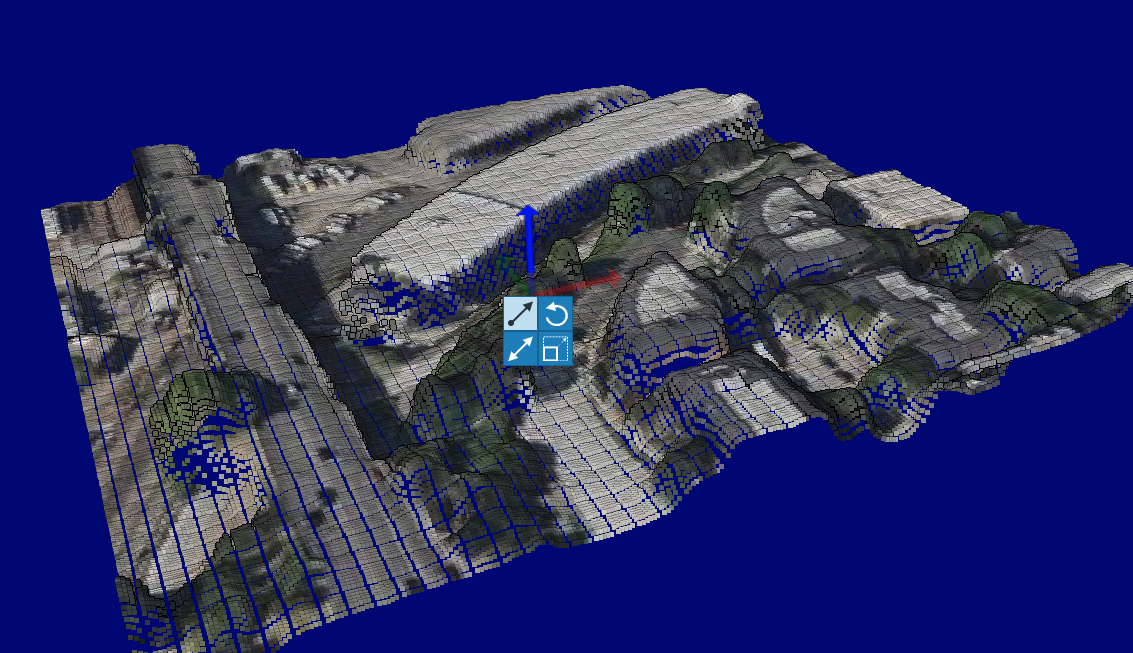

## Step 3: Creating a mesh 

While the point cloud is a decent way to visualise the 3D data, meshes are quite useful. PyVista is a package that makes creating a mesh from the point cloud we generated very simple, although if you've used a zoom level greater than 17, this can take a while.

In [9]:
# We've got color in the pointcloud object in columns 4-6, so remove those before passing to pvista

points = np.array(pointcloud)[:,:3]
points

import numpy as np
import pyvista as pv

# points is a 3D numpy array (n_points, 3) coordinates of a sphere
cloud = pv.PolyData(points)


The cells below will run very slowly on zoom levels 18 and higher, but attain much better results. There are more efficient alternatives to creating meshes outside of Python, and the examples below are really intended to show what's possible rather than the optimal way to get there.

In [10]:
volume = cloud.delaunay_3d(alpha=4)
shell = volume.extract_geometry()

2021-12-16 11:16:55.432 (  26.110s) [         158410B]            vtkMath.cxx:596   WARN| Unable to factor linear system


In [12]:
shell.texture_map_to_plane(inplace=True)
tex = pv.numpy_to_texture(rgb_array)
shell.plot(texture=tex, jupyter_backend='pythreejs')

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(color='#fefefe', inten…